In [63]:
# The following code is coppied and adapted from the following webpage:
# https://www.geeksforgeeks.org/emotion-detection-using-bidirectional-lstm/
# Addionally the attention layer is coppied and adapted from the following page:
# https://github.com/philipperemy/keras-attention/tree/master

In [76]:
# Importing the required libraries
import keras
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.layers import *
from sklearn.model_selection import cross_val_score,train_test_split
import nltk
import pandas as pd
import tensorflow as tf


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('text_emotion_isear_edit2.csv', header=1)

In [3]:
#Changed a bit as now we have a DataFrame
df.drop(df[df['SIT'] == '[ No response.]'].index, inplace = True)
#let's get rid of anger and disgust to have a try
df = df[~df['EMOTION'].isin(['guilt', 'disgust'])]
print (df['EMOTION'].value_counts() )

number_emotions = df['EMOTION'].unique()

EMOTION
fear       1074
sadness    1068
anger      1062
joy        1061
shame      1060
Name: count, dtype: int64


In [4]:

#make all contexts (sentences) in dataset a list
texts =df["SIT"]

#HIGHTLIGHT
#Convert each text value to lowercase using the .str.lower() method
lower_texts = texts.str.lower()

# Each  sentence in feel_arr is tokenized by the help of work tokenizer.
# If I have a sentence - 'I am happy'. 
# After word tokenizing it will convert into- ['I','am','happy']
lower_texts = [word_tokenize(sent) for sent in lower_texts]

#Now I added some codes to see how many words it has for the longest text
longest_text = max(lower_texts, key=len)
print (longest_text)
print("Sublist with the most elements:", len(longest_text))

['this', 'is', 'an', 'event', 'i', 'will', 'never', 'forget', '.', 'i', 'am', 'considered', 'a', 'good', 'ã¡', 'mimic', '.', 'this', 'particular', 'day', 'we', 'were', 'waiting', 'for', 'a', 'professor', 'ã¡', 'to', 'take', 'her', 'class', '.', 'this', 'professor', 'had', 'a', 'peculiar', 'accent', 'and', 'a', 'ã¡', 'very', 'horrible', 'way', 'of', 'lecturing', 'and', 'to', 'top', 'it', 'all', 'we', 'had', 'this', 'ã¡', 'class', 'at', 'the', 'fag', 'end', 'of', 'the', 'day', '.', 'so', 'this', 'particular', 'day', 'i', 'got', 'ã¡', 'into', 'my', 'element', 'and', 'started', 'imitating', 'the', 'professor', ',', 'and', 'the', 'ã¡', 'professor', 'entered', 'the', 'class', 'right', 'in', 'the', 'middle', 'of', 'it', '.', 'i', 'was', 'ã¡', 'unaware', 'of', 'her', 'presence', ',', 'some', 'of', 'my', 'friends', 'tried', 'to', 'warn', 'me', 'but', 'ã¡', 'it', 'was', 'of', 'no', 'avail', 'as', 'i', 'was', 'too', 'engrossed', 'in', 'mimicing', '.', 'then', 'i', 'ã¡', 'suddenly', 'noticed', 'th

In [5]:

# Defined a function padd in which each sentence length is fixed to 200.
# If length is less than 200 , then the word- '<padd>' is append
def padd(arr):
    for i in range(200-len(arr)):
        arr.append('<pad>')
    return arr[:200]
   
# call the padd function for each sentence in feel_arr
for i in range(len(lower_texts)):
    lower_texts[i]=padd(lower_texts[i])
 

# Glove vector contains a 50 dimensional vector corresponding 
# to each word in dictionary.
vocab_f = 'glove.6B.50d.txt'
 
# embeddings_index is a dictionary which contains the mapping of
# word with its corresponding 50d vector.
embeddings_index = {}
with open(vocab_f, encoding='utf8') as f:
    for line in f:
        # splitting each line of the glove.6B.50d in a list of 
        # items- in which the first element is the word to be embedded,
        # and from second to the end of line contains the 50d vector.
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
         
# Embedding each word of the feel_arr
embedding_texts = []
# Iterate through each sub-list (sentences)
for word_list in lower_texts:
    # Initialize an empty list to store the embedding vectors for each word
    word_vectors = []
    for word in word_list:
        if word in embeddings_index:
            word_vector = embeddings_index[word]
            word_vectors.append(word_vector)
        else:
            # if the word to be embedded is '<padd>' append 0 fifty times
            word_vector = np.zeros(50, dtype='float32')
            word_vectors.append(word_vector)
    embedding_texts.append(word_vectors)


In [34]:
#embeeding_texts cannot be a list, for the website he made it NumPy-array
X = np.array(embedding_texts)

#One-Hot Encoding for all emotions, 
#instead of just give them numbers, by doing so we will have seven outputs
Y = pd.get_dummies(df['EMOTION'], prefix='emotion')

# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,random_state=2)

KeyError: 'EMOTION'

In [23]:
"""
class BiLSTMModel:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Input(shape=(200, 50)))
        
        self.model.add(Bidirectional(LSTM(64, input_shape=(200, 50))))

        self.model.add(Dropout(0.2))
        
        self.model.add(Dense(5, activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
    def fit(self, X, Y, epochs, batch_size,verbose):
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size,verbose=verbose)
 
    def evaluate(self, X, Y, batch_size,verbose):
        return self.model.evaluate(X, Y, batch_size=batch_size,verbose=verbose)
 
    def predict(self, X):
        return self.model.predict(X)
"""


"\nclass BiLSTMModel:\n    def __init__(self):\n        self.model = Sequential()\n        self.model.add(Input(shape=(200, 50)))\n        \n        self.model.add(Bidirectional(LSTM(64, input_shape=(200, 50))))\n\n        self.model.add(Dropout(0.2))\n        \n        self.model.add(Dense(5, activation='softmax'))\n        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])\n \n    def fit(self, X, Y, epochs, batch_size,verbose):\n        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size,verbose=verbose)\n \n    def evaluate(self, X, Y, batch_size,verbose):\n        return self.model.evaluate(X, Y, batch_size=batch_size,verbose=verbose)\n \n    def predict(self, X):\n        return self.model.predict(X)\n"

In [66]:
import os
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer, RepeatVector, Add


# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer, and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))

@keras.saving.register_keras_serializable()
# References:
# - https://arxiv.org/pdf/1508.04025.pdf (Luong).
# - https://arxiv.org/pdf/1409.0473.pdf (Bahdanau).
# - https://machinelearningmastery.com/the-bahdanau-attention-mechanism/ (Some more explanation).

class Attention(object if debug_flag else Layer):
    SCORE_LUONG = 'luong'
    SCORE_BAHDANAU = 'bahdanau'

    def __init__(self, units: int = 128, score: str = 'luong', **kwargs):
        super(Attention, self).__init__(**kwargs)
        if score not in {self.SCORE_LUONG, self.SCORE_BAHDANAU}:
            raise ValueError(f'Possible values for score are: [{self.SCORE_LUONG}] and [{self.SCORE_BAHDANAU}].')
        self.units = units
        self.score = score

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            # W in W*h_S.
            if self.score == self.SCORE_LUONG:
                self.luong_w = Dense(input_dim, use_bias=False, name='luong_w')
                # dot : last hidden state H_t and every hidden state H_s.
                self.luong_dot = Dot(axes=[1, 2], name='attention_score')
            else:
                # Dense implements the operation: output = activation(dot(input, kernel) + bias)
                self.bahdanau_v = Dense(1, use_bias=False, name='bahdanau_v')
                self.bahdanau_w1 = Dense(input_dim, use_bias=False, name='bahdanau_w1')
                self.bahdanau_w2 = Dense(input_dim, use_bias=False, name='bahdanau_w2')
                self.bahdanau_repeat = RepeatVector(input_shape[1])
                self.bahdanau_tanh = Activation('tanh', name='bahdanau_tanh')
                self.bahdanau_add = Add()

            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')

            # exp / sum(exp) -> softmax.
            self.softmax_normalizer = Activation('softmax', name='attention_weight')

            # dot : score * every hidden state H_s.
            # dot product. SUM(v1*v2). H_s = every source hidden state.
            self.dot_context = Dot(axes=[1, 1], name='context_vector')

            # [Ct; ht]
            self.concat_c_h = Concatenate(name='attention_output')

            # x -> tanh(w_c(x))
            self.w_c = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras. Supports:
            - Luong's multiplicative style.
            - Bahdanau's additive style.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: philipperemy, felixhao28.
        """
        h_s = inputs
        if debug_flag:
            self.build(h_s.shape)
        h_t = self.h_t(h_s)
        if self.score == self.SCORE_LUONG:
            # Luong's multiplicative style.
            score = self.luong_dot([h_t, self.luong_w(h_s)])
        else:
            # Bahdanau's additive style.
            self.bahdanau_w1(h_s)
            a1 = self.bahdanau_w1(h_t)
            a2 = self.bahdanau_w2(h_s)
            a1 = self.bahdanau_repeat(a1)
            score = self.bahdanau_tanh(self.bahdanau_add([a1, a2]))
            score = self.bahdanau_v(score)
            score = K.squeeze(score, axis=-1)

        alpha_s = self.softmax_normalizer(score)
        context_vector = self.dot_context([h_s, alpha_s])
        a_t = self.w_c(self.concat_c_h([context_vector, h_t]))
        return a_t

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units, 'score': self.score})
        return config

In [67]:
'''
@keras.saving.register_keras_serializable()
class Attention(Layer):
    def __init__(self, attention_size, **kwargs):
        self.attention_size = attention_size
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # W: (EMBED_SIZE, ATTENTION_SIZE)
        # b: (ATTENTION_SIZE, 1)
        # u: (ATTENTION_SIZE, 1)
        self.W = self.add_weight(name="W_{:s}".format(self.name),
                                 shape=(input_shape[-1], self.attention_size),
                                 initializer="glorot_normal",
                                 trainable=True)
        self.b = self.add_weight(name="b_{:s}".format(self.name),
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="u_{:s}".format(self.name),
                                 shape=(self.attention_size, 1),
                                 initializer="glorot_normal",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        # input: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        # et: (BATCH_SIZE, MAX_TIMESTEPS, ATTENTION_SIZE)
        et = K.tanh(K.dot(x, self.W) + self.b)
        # at: (BATCH_SIZE, MAX_TIMESTEPS)
        at = K.softmax(K.squeeze(K.dot(et, self.u), axis=-1))
        if mask is not None:
            at *= K.cast(mask, K.floatx())
        # ot: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        atx = K.expand_dims(at, axis=-1)
        ot = atx * x
        # output: (BATCH_SIZE, EMBED_SIZE)
        output = K.sum(ot, axis=1)
        return output

    def compute_mask(self, input, input_mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
'''

'\n@keras.saving.register_keras_serializable()\nclass Attention(Layer):\n    def __init__(self, attention_size, **kwargs):\n        self.attention_size = attention_size\n        super(Attention, self).__init__(**kwargs)\n\n    def build(self, input_shape):\n        # W: (EMBED_SIZE, ATTENTION_SIZE)\n        # b: (ATTENTION_SIZE, 1)\n        # u: (ATTENTION_SIZE, 1)\n        self.W = self.add_weight(name="W_{:s}".format(self.name),\n                                 shape=(input_shape[-1], self.attention_size),\n                                 initializer="glorot_normal",\n                                 trainable=True)\n        self.b = self.add_weight(name="b_{:s}".format(self.name),\n                                 shape=(input_shape[1], 1),\n                                 initializer="zeros",\n                                 trainable=True)\n        self.u = self.add_weight(name="u_{:s}".format(self.name),\n                                 shape=(self.attention_size, 1),\n     

In [68]:
from tensorflow.keras.layers import Layer, Bidirectional, LSTM, Input, Dense, Dropout
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K




input_layer = Input(shape=(200, 50))

# Creating a Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(input_layer)

# Creating an Attention Layer
attention = Attention(units=128)(lstm_layer)

# Add a Dropout Layer after the Attention Layer.
dropout_layer = Dropout(0.2)(attention)  # The 0.2 here represents the dropout rate

# Adding other layers after the attention layer, e.g., a fully connected layer
output_layer = tf.keras.layers.Dense(5, activation="softmax")(attention)


# 创建模型
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [69]:
#model = BiLSTMModel()
# Take a look of the model layers summarry
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 200, 50)]         0         
                                                                 
 bidirectional_12 (Bidirect  (None, 200, 128)          58880     
 ional)                                                          
                                                                 
 attention_12 (Attention)    (None, 128)               49152     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 108677 (424.52 KB)
Trainable params: 108677 (424.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
class BiLSTMModel:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Input(shape=(200, 50)))
        
        self.model.add(Bidirectional(LSTM(64, input_shape=(200, 50))))

        self.model.add(Dropout(0.2))
        
        self.model.add(Dense(5, activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
    def fit(self, X, Y, epochs, batch_size,verbose):
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size,verbose=verbose)
 
    def evaluate(self, X, Y, batch_size,verbose):
        return self.model.evaluate(X, Y, batch_size=batch_size,verbose=verbose)
 
    def predict(self, X):
        return self.model.predict(X)

In [58]:
# fit the model on the input and target data
model.fit(X_train,Y_train, epochs=7, batch_size=16,verbose=1)

Epoch 1/7
267/267 [==============================] - 13s 39ms/step - loss: 1.4050 - accuracy: 0.3883
Epoch 2/7
267/267 [==============================] - 10s 38ms/step - loss: 1.0445 - accuracy: 0.5995
Epoch 3/7
267/267 [==============================] - 10s 38ms/step - loss: 0.9565 - accuracy: 0.6237
Epoch 4/7
267/267 [==============================] - 10s 38ms/step - loss: 0.8905 - accuracy: 0.6521
Epoch 5/7
267/267 [==============================] - 10s 39ms/step - loss: 0.8382 - accuracy: 0.6695
Epoch 6/7
267/267 [==============================] - 10s 38ms/step - loss: 0.7843 - accuracy: 0.7035
Epoch 7/7
267/267 [==============================] - 10s 38ms/step - loss: 0.7334 - accuracy: 0.7185


In [59]:
#now we can check the performance of the model with the testing sets
loss,accuracy = model.evaluate(X_test, Y_test, 16,verbose = 0)
print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 0.9697664380073547
Accuracy: 0.65727698802948


In [70]:
# Define the number of training epochs and batch size
epochs = 15
batch_size = 16

# Create empty lists to store training and test accuracy
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(epochs):
    # Train the model for one epoch
    history = model.fit(X_train,Y_train, epochs=1, batch_size=16,verbose=0)
    # Calculate training accuracy
    train_accuracy = history.history['accuracy'][0]
    train_accuracy_history.append(train_accuracy)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1/15
Train Accuracy: 0.3408, Test Accuracy: 0.4141
Epoch 2/15
Train Accuracy: 0.5481, Test Accuracy: 0.5934
Epoch 3/15
Train Accuracy: 0.6141, Test Accuracy: 0.6075
Epoch 4/15
Train Accuracy: 0.6545, Test Accuracy: 0.6488
Epoch 5/15
Train Accuracy: 0.6791, Test Accuracy: 0.6667
Epoch 6/15
Train Accuracy: 0.6941, Test Accuracy: 0.6620
Epoch 7/15
Train Accuracy: 0.7129, Test Accuracy: 0.6516
Epoch 8/15
Train Accuracy: 0.7387, Test Accuracy: 0.6667
Epoch 9/15
Train Accuracy: 0.7678, Test Accuracy: 0.6488
Epoch 10/15
Train Accuracy: 0.7869, Test Accuracy: 0.6751
Epoch 11/15
Train Accuracy: 0.8052, Test Accuracy: 0.6723
Epoch 12/15
Train Accuracy: 0.8265, Test Accuracy: 0.6460
Epoch 13/15
Train Accuracy: 0.8509, Test Accuracy: 0.6451
Epoch 14/15
Train Accuracy: 0.8669, Test Accuracy: 0.6460
Epoch 15/15
Train Accuracy: 0.8845, Test Accuracy: 0.6404


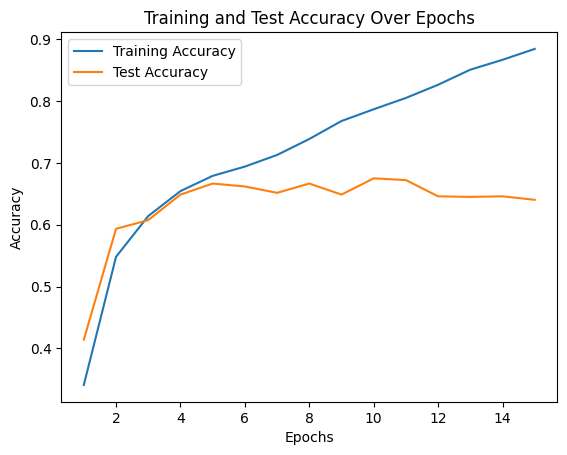

In [71]:
import matplotlib.pyplot as plt


# set for x axis range
epochs_range = range(1, epochs + 1)

# Plot line graphs of training accuracies and test accuracies
plt.plot(epochs_range, train_accuracy_history, label="Training Accuracy")
plt.plot(epochs_range, test_accuracy_history, label="Test Accuracy")

# Add title and tags
plt.title("Training and Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# add Legend
plt.legend()


In [18]:
Y_test

,emotion_anger,emotion_fear,emotion_joy,emotion_sadness,emotion_shame
1144,True,False,False,False,False
7106,False,False,False,False,True
296,True,False,False,False,False
3,False,False,False,True,False
1313,False,False,False,False,True
...,...,...,...,...,...
6022,False,False,False,False,True
2962,False,False,False,False,True
3721,False,True,False,False,False
1035,False,True,False,False,False


In [72]:
# Prediction using models
predictions = model.predict(X_test)

# Initialize a dictionary to store the number of correct predictions and the total number of correct predictions for each sentiment classification
accuracy_dict = {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0]}


predicted_labels = np.argmax(predictions, axis=1)

true_labels = []
for index, row in Y_test.iterrows():
    true_label_index = np.argmax(row.to_numpy())  # Index for finding the sentiment classification with the highest probability
    true_labels.append(true_label_index)

true_labels = np.array(true_labels)

# Iterate over test data and labels to calculate accuracy
for i in range(len(X_test)):
    true_label = true_labels [i]
    predicted_label = predicted_labels[i]
    accuracy_dict[true_label][1] += 1  
    if true_label == predicted_label:
        accuracy_dict[true_label][0] += 1  

# Calculate accuracy for each sentiment classification and print the results
for emotion, [correct, total] in accuracy_dict.items():
    if total > 0:
        accuracy = correct / total
        print(f"Accuracy (Emotion {emotion}): {accuracy:.2f}")
    else:
        print(f"No test data for Emotion {emotion}")

34/34 [==============================] - 1s 18ms/step
Accuracy (Emotion 0): 0.66
Accuracy (Emotion 1): 0.68
Accuracy (Emotion 2): 0.71
Accuracy (Emotion 3): 0.65
Accuracy (Emotion 4): 0.52


In [73]:
# make it a DataFrame
merged_train_accuracy_history = df = pd.DataFrame({
    'train_accuracy_history': train_accuracy_history,
    'test_accuracy_history': test_accuracy_history
})


# Export data to CSV file
file_name = f"SK_accuracy_epochs_{epochs}_batch_{batch_size}.csv"
df.to_csv(file_name, index=False)

In [75]:
#Uncomment this piece of code if you want to save the model 

model.save('1trained_model_Sikai_20231020_1.h5')  # creates a HDF5 file 'xxxxx.h5'
#del model  # deletes the existing model
    
#returns a compiled model
#identical to the previous one
#model = load_model('')